In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [2]:
# read in the data
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')
risks = pd.read_csv("../data/EDIndex20221202.csv")

In [3]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))


In [4]:
# compute the weighted distance between nodes using dijkstra's algorithm
# 3500 kilometers is the distance from Lagos to Dakar, the ends of a corridor according to the literature
%time distances = dict(nx.all_pairs_dijkstra_path_length(G, weight='l', cutoff=3500))

CPU times: user 22.1 s, sys: 209 ms, total: 22.3 s
Wall time: 22.3 s


In [5]:
# get the index values for roads, which are labeled as 'road' in the 'agglosName' attribute with the node data
junctions = [n for n, d in G.nodes(data=True) if d['agglosName']=='road']

In [6]:
# how many nodes to we start out with?
len(G.nodes())

7361

In [7]:
# remove entries in the dictionary that are junctions, del for delete
for k in junctions:
    del distances[k]

In [8]:
# check to see that we are down to just the cities
len(distances)

2162

In [9]:
# for each entry in distances, remove the self-loops
for i in distances:
    del distances[i][i]

In [10]:
# convert distances to data frame then melt all columns into a single column
pathlengths = pd.DataFrame(distances).reset_index().melt(id_vars='index', var_name='to', value_name='distance')
pathlengths = pathlengths.reset_index(drop=True).rename(columns={'index':'from'})
pathlengths = pathlengths[pathlengths['from']!=pathlengths['to']].reset_index(drop=True)
pathlengths.head()

,from,to,distance
0,5425,8211,0.798800
1,1000559,8211,1.113085
2,1000567,8211,1.314500
3,2333,8211,4.294382
4,1027090,8211,4.532485


In [11]:
nodes = nodes.set_index('Agglomeration_ID')
nodes.head()

,agglosName,x,y,Pop2015,ISO3,Region,Between,degree
Agglomeration_ID,,,,,,,,
2320,Cairo,31.324,30.130,22995802,EGY,North,6.979617e+07,6
5199,Lagos,3.316,6.668,11847635,NGA,West,3.127663e+07,4
7098,Onitsha,6.928,5.815,8530514,NGA,West,2.110388e+07,6
4220,Johannesburg,28.016,-26.050,8314220,ZAF,South,3.568974e+07,5
4858,Kinshasa,15.293,-4.408,7270000,COD,Central,1.119784e+06,4


In [12]:
# compute a gravity model with population and distance
def gravity(distances, nodes, alpha=1, beta=1):
    # compute the denominator
    denominator = 0
    for i in distances:
        for j in distances[i]:
            denominator += (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015'])
    
    # compute the gravity model
    gravity = {}
    for i in distances:
        gravity[i] = {}
        for j in distances[i]:
            gravity[i][j] = (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015']) / denominator
    
    return gravity

# wrap it into a data frame
def flow_dataframe(flows):
    df = pd.DataFrame(flows).reset_index().melt(id_vars='index', var_name='to', value_name='flow')
    df = df.reset_index(drop=True).rename(columns={'index':'from'})
    df = df[df['from']!=df['to']].reset_index(drop=True)
    return df

In [13]:
%time flows = flow_dataframe(gravity(distances, nodes, beta=1.6))

CPU times: user 1min 30s, sys: 112 ms, total: 1min 30s
Wall time: 1min 30s


In [14]:
# these flows sum to 1 and should represent the proportion of total flows in Africa
flows['flow'].sum()

0.9999999999999541

In [15]:
# filter flows out flows that are less than 0 
flows_trimmed = flows[flows['flow']>0].reset_index(drop=True)

In [16]:
# colorcet is a great library for color palettes
import colorcet as cc

In [17]:
# get shortest paths
paths = dict(nx.all_pairs_dijkstra_path(G, weight='l', cutoff=3500))

In [18]:
# convert paths to a dataframe, reset the index and melt the data
paths = pd.DataFrame(paths).reset_index().melt(id_vars='index', var_name='to', value_name='path')
paths = paths.reset_index(drop=True).rename(columns={'index':'from'})

In [19]:
# filter paths that are in the flows dataframe
print(paths.shape)
paths = paths[paths['from'].isin(flows_trimmed['from']) & paths['to'].isin(flows_trimmed['to'])].reset_index(drop=True)
print(paths.shape)

(54184321, 3)
(4674244, 3)


In [20]:
# remove self loops
paths = paths[paths['from']!=paths['to']].reset_index(drop=True)
# remove nan values
paths = paths[paths['path'].notnull()].reset_index(drop=True)
paths.head()

,from,to,path
0,2333,8211,"[8211, 2333]"
1,5425,8211,"[8211, 5425]"
2,8208,8211,"[8211, 8208]"
3,3833,8211,"[8211, 2333, 3833]"
4,1364,8211,"[8211, 2333, 1068481, 1364]"


In [21]:
# map over paths to get pairs in a moving window
def get_pairs(path):
    pairs = []
    for i in range(len(path)-1):
        pairs.append((path[i], path[i+1]))
    return pairs

# map over paths to get pairs in a moving window
paths['pairs'] = paths['path'].map(get_pairs)

In [22]:
# expand pairs column so that each element of the list becomes a row
paths = paths.explode('pairs').reset_index(drop=True)

# rename from, to columns into origin and destination
paths = paths.rename(columns={'from':'origin', 'to':'destination'})

# split pairs into from and to columns
paths[['from', 'to']] = pd.DataFrame(paths['pairs'].tolist(), index=paths.index)
paths.head()

,origin,destination,path,pairs,from,to
0,2333,8211,"[8211, 2333]","(8211, 2333)",8211,2333
1,5425,8211,"[8211, 5425]","(8211, 5425)",8211,5425
2,8208,8211,"[8211, 8208]","(8211, 8208)",8211,8208
3,3833,8211,"[8211, 2333, 3833]","(8211, 2333)",8211,2333
4,3833,8211,"[8211, 2333, 3833]","(2333, 3833)",2333,3833


In [23]:
# join the paths with the flows dataframe
flows_imputed = paths.merge(flows_trimmed, left_on=['origin', 'destination'], right_on=['from', 'to'], how='left')

# rename from_x and to_x columns into from and to
flows_imputed = flows_imputed.rename(columns={'from_x':'from', 'to_x':'to'})

# select from, to, flow, flow_delayed, flow_reduced columns
flows_imputed = flows_imputed[['from', 'to', 'flow']]

# group by from, to and sum the flows
flows_imputed = flows_imputed.groupby(['from', 'to'], as_index=False).sum()

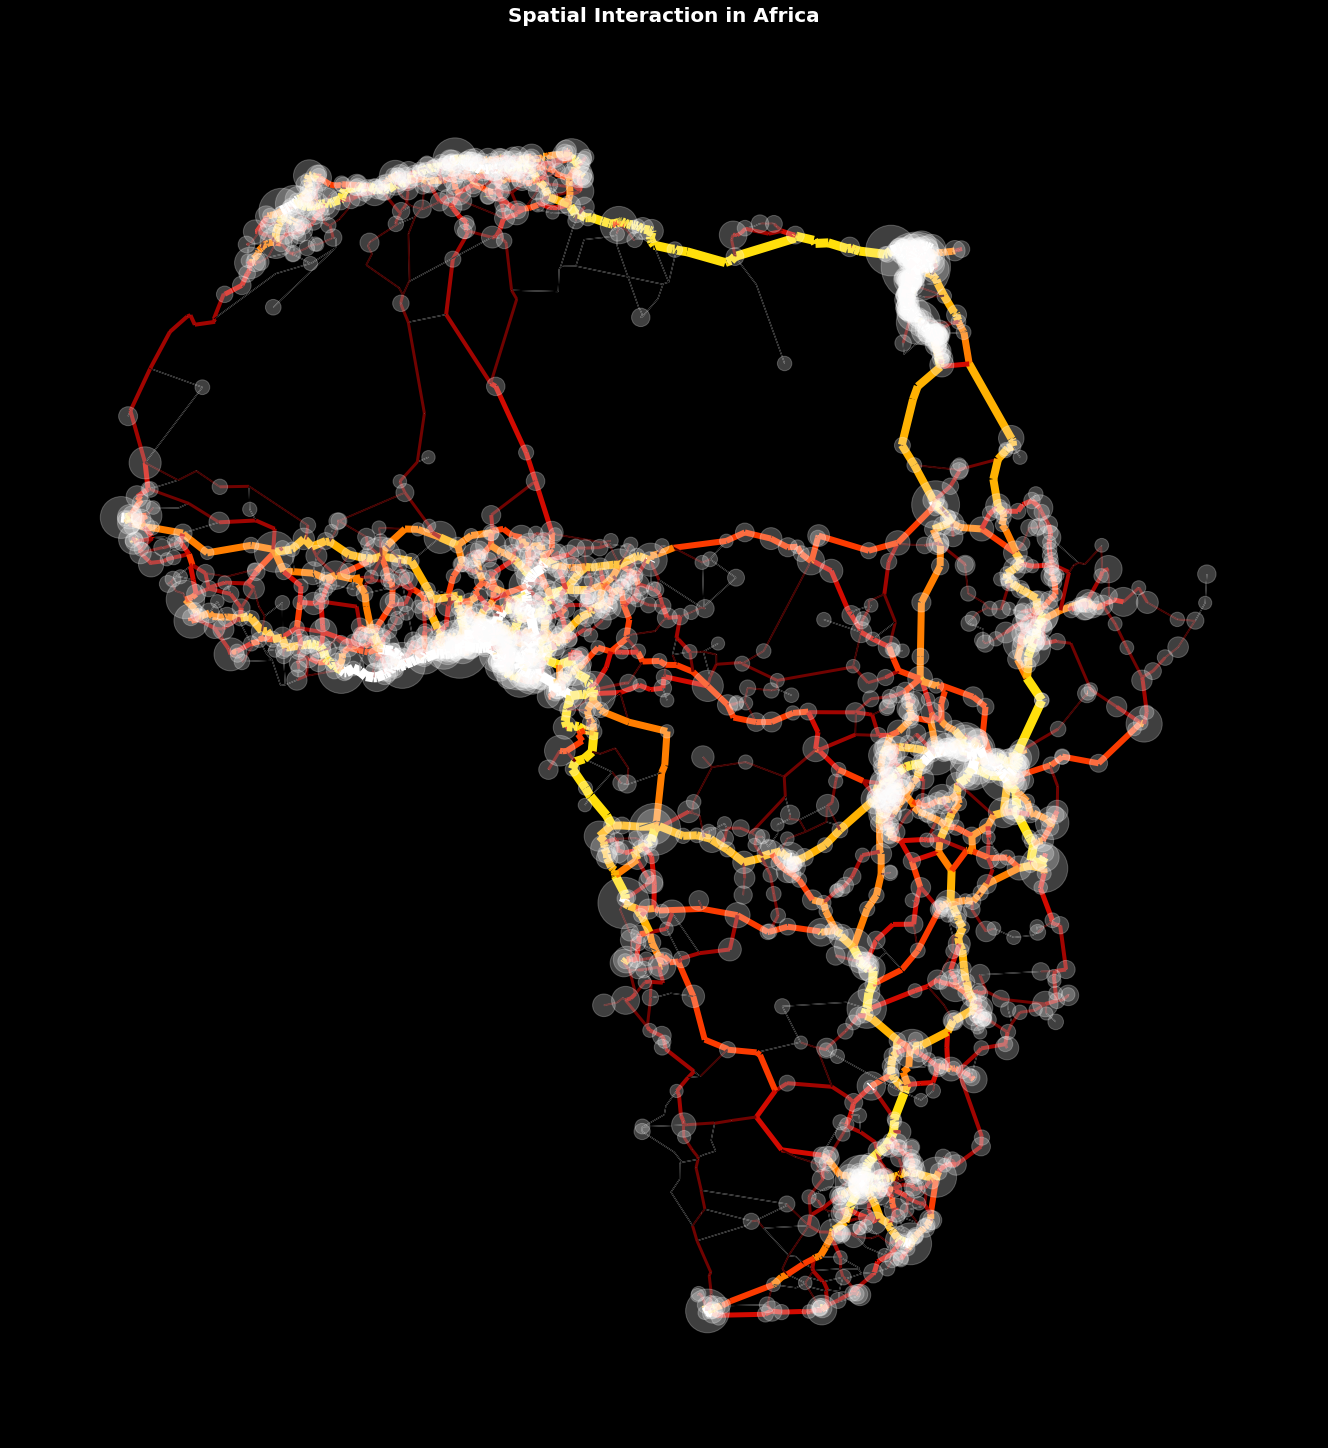

In [24]:
# create a networkx graph from the flows_imputed dataframe
G_imputed = nx.from_pandas_edgelist(flows_imputed, source='from', target='to', edge_attr=['flow'])

# add node attributes
nx.set_node_attributes(G_imputed, nodes.to_dict('index'))

# plot the network
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

# set the node positions
pos = dict(zip(list(G_imputed.nodes()), [[v['x'], v['y']] for k, v in G_imputed.nodes(data=True)]))

# set the node size
node_size = [d['Pop2015'] for k, d in G_imputed.nodes(data=True)]

# draw the nodes
nx.draw_networkx_nodes(G_imputed, pos=pos, node_size=np.sqrt(node_size), node_color='w', alpha=0.25, ax=ax)

# get edge colors
edge_color = [d['flow'] for u, v, d in G_imputed.edges(data=True)]

# break it up into quantiles
edge_color = pd.qcut(edge_color, 10, labels=False)

# draw the edges colored by the flow
nx.draw_networkx_edges(G_imputed, pos=pos, edge_color='w', width=1, ax=ax)
nx.draw_networkx_edges(G_imputed, pos=pos, edge_color=edge_color, width=edge_color + 1, ax=ax, edge_cmap=cc.cm.fire)

# set axis to black
ax.set_facecolor('k')

# turn axis off
ax.set_axis_off()

# set the title
ax.set_title('Spatial Interaction in Africa', color='w', fontsize=20, fontweight='bold')

# save the figure
plt.savefig('africaspint.png', dpi=300, facecolor='k', bbox_inches='tight')

In [25]:
# this script just checks to make sure that lines not present in the plot are still in the data, just with low values that must be getting filtered out
from shapely.geometry import Point, LineString

# convert nodes to a dataframe
nl = pd.DataFrame.from_dict(dict(G_imputed.nodes(data=True)), orient='index').reset_index().rename(columns={'index':'Agglomeration_ID', 'Region':'region'})
# convert x, y to geometry
nl['geometry'] = nl.apply(lambda x: Point(x['x'], x['y']), axis=1)
# convert to geodataframe
nl = gpd.GeoDataFrame(nl, geometry='geometry')
nl = nl[['Agglomeration_ID', 'region', 'geometry']]

# convert edges to a dataframe
el = nx.to_pandas_edgelist(G_imputed)

# merge the nodes with the edges
el = el.merge(nl, left_on='source', right_on='Agglomeration_ID', how='left').rename(columns={'geometry':'from_geometry', 'region':'from_region'})
el = el.merge(nl, left_on='target', right_on='Agglomeration_ID', how='left').rename(columns={'geometry':'to_geometry', 'region':'to_region'})

# convert the two points to a single line
el['geometry'] = el.apply(lambda x: LineString([x['from_geometry'], x['to_geometry']]), axis=1)

# convert to geodataframe
el = gpd.GeoDataFrame(el, geometry='geometry', crs='epsg:4326')
el = el[['source', 'target', 'flow', 'geometry', 'from_region', 'to_region']]

# el.explore()
el.head()


/Users/asr/opt/anaconda3/envs/locomizer/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/asr/opt/anaconda3/envs/locomizer/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,source,target,flow,geometry,from_region,to_region
0,1,1230,0.000094,"LINESTRING (31.74100 30.28800, 31.45600 30.34300)",North,North
1,1,1891,0.001065,"LINESTRING (31.74100 30.28800, 31.55000 30.40500)",North,North
2,1,2320,0.009511,"LINESTRING (31.74100 30.28800, 31.32400 30.13000)",North,North
3,1,1002523,0.000004,"LINESTRING (31.74100 30.28800, 31.90830 29.78073)",North,North
4,1,1046839,0.000026,"LINESTRING (31.74100 30.28800, 31.86811 30.09149)",North,North


In [26]:
el['crossing'] = el['from_region'] != el['to_region']

In [27]:
region = []

for row in el.iterrows():
    if row[1]['crossing']: 
        region = np.append(region, "crossing")
    else: 
        region = np.append(region, row[1]['from_region'])

In [28]:
el['region'] = region
el.head()

,source,target,flow,geometry,from_region,to_region,crossing,region
0,1,1230,0.000094,"LINESTRING (31.74100 30.28800, 31.45600 30.34300)",North,North,False,North
1,1,1891,0.001065,"LINESTRING (31.74100 30.28800, 31.55000 30.40500)",North,North,False,North
2,1,2320,0.009511,"LINESTRING (31.74100 30.28800, 31.32400 30.13000)",North,North,False,North
3,1,1002523,0.000004,"LINESTRING (31.74100 30.28800, 31.90830 29.78073)",North,North,False,North
4,1,1046839,0.000026,"LINESTRING (31.74100 30.28800, 31.86811 30.09149)",North,North,False,North


In [29]:
joined = el.merge(risks, left_on=['source', 'target'], right_on=['from', 'to'], how='left')
joined = joined[['source', 'target', 'flow', 'region', 'index', 'geometry']].rename(columns={'index':'risk'})
joined = joined.fillna(0)
joined.head()

,source,target,flow,region,risk,geometry
0,1,1230,0.000094,North,2.577277,"LINESTRING (31.74100 30.28800, 31.45600 30.34300)"
1,1,1891,0.001065,North,1.922548,"LINESTRING (31.74100 30.28800, 31.55000 30.40500)"
2,1,2320,0.009511,North,0.000000,"LINESTRING (31.74100 30.28800, 31.32400 30.13000)"
3,1,1002523,0.000004,North,1.286221,"LINESTRING (31.74100 30.28800, 31.90830 29.78073)"
4,1,1046839,0.000026,North,1.288002,"LINESTRING (31.74100 30.28800, 31.86811 30.09149)"


In [30]:
# crosswalk = pd.DataFrame({'region': np.unique(region),
#                           'color': np.random.choice(cc.palette['glasbey_light'], len(np.unique(region)))})

# joined = joined.merge(crosswalk, left_on='region', right_on='region', how='left')

In [31]:
crosswalk = {
    'region': ['Central', 'East', 'North', 'South', 'West', 'crossing'],
    'color': ['#a0e491', '#48ffef', '#ef72aa', '#00cff9', '#953f1f', '#7c7c7c']
}

crosswalk = pd.DataFrame(crosswalk)

joined = joined.merge(crosswalk, left_on='region', right_on='region', how='left')

(-0.25, 5.25, -0.05500000000000001, 0.05500000000000001)

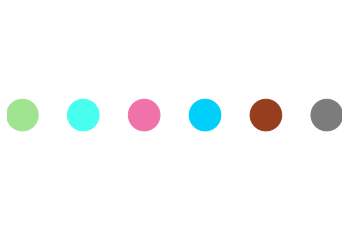

In [32]:
# scatter plot where each dot is a row of the crosswalk and the color is the color column
plt.scatter(np.arange(len(crosswalk)), np.zeros(len(crosswalk)), c=crosswalk['color'], s=1000)
plt.axis('off')

In [33]:
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]

Text(0.5, 0.98, 'Relationship Between Risk and Importance')

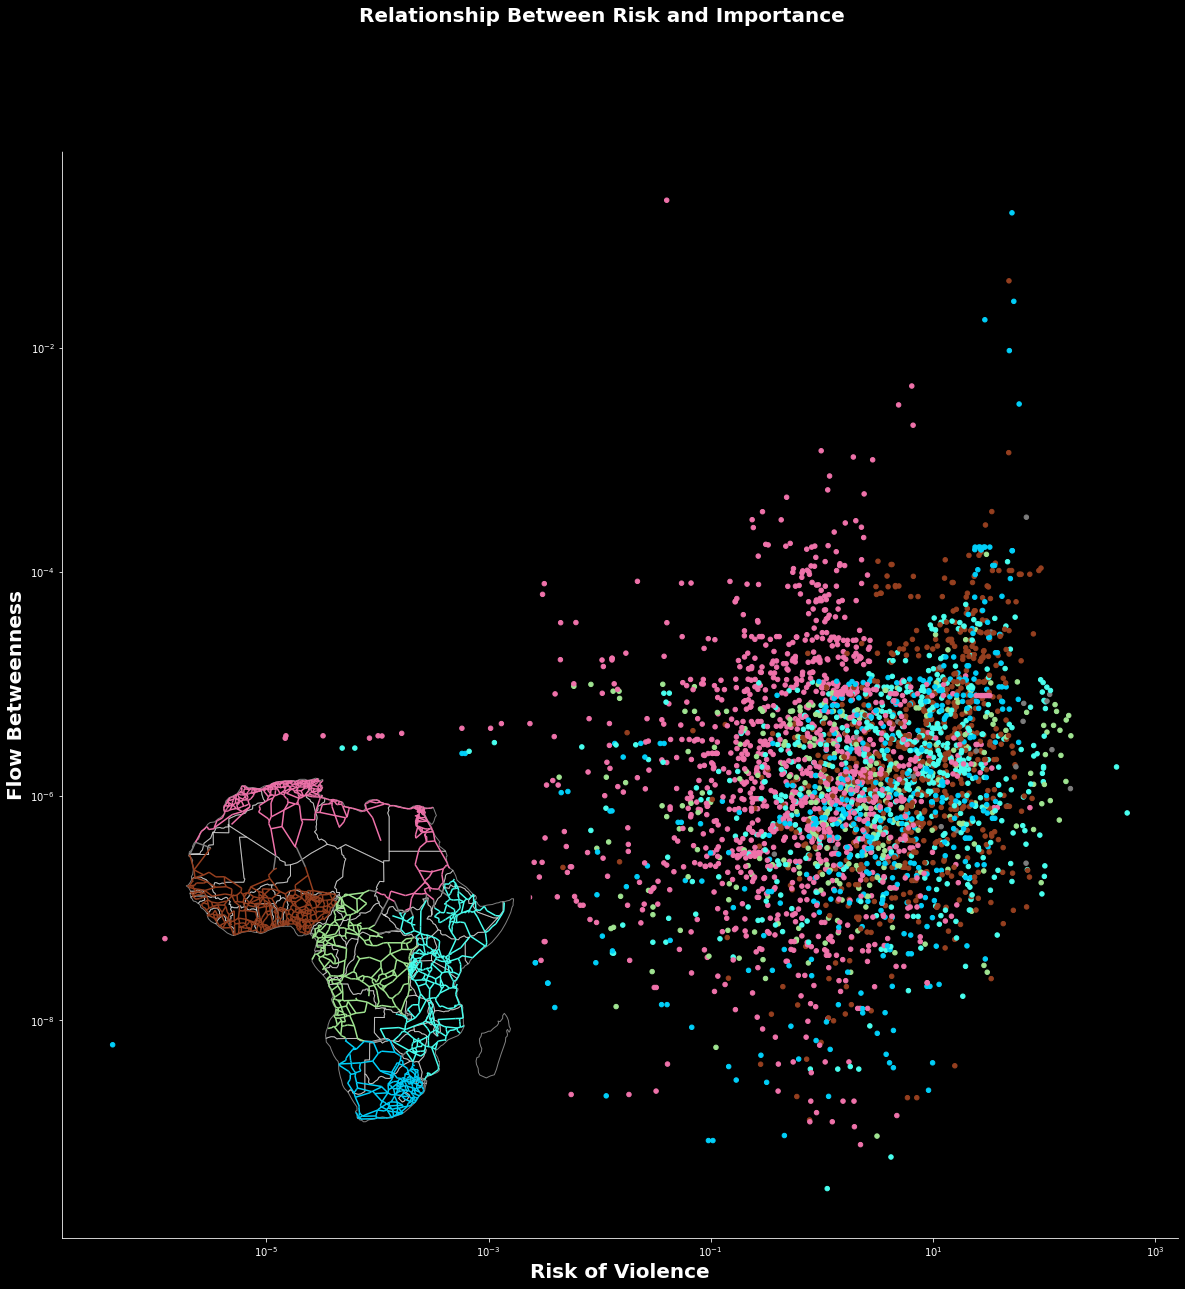

In [34]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')

joined[['risk', 'flow']].plot('risk', 'flow', color=joined['color'], kind='scatter', ax=ax)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("Risk of Violence", color="w", fontdict=font)
ax.set_ylabel("Flow Betweenness", color="w", fontdict=font)

sub = plt.axes([0.2, 0.05] + [0.25, 0.55], facecolor='#000000')
africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)
joined.plot(color=joined['color'], ax=sub)

# legend = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
# legend = legend.merge(crosswalk, left_on='Region', right_on='region', how='left')
# legend.head()

# import math
# legend['markersize'] = np.sqrt(legend['Pop2015'] / 100000)

# legend.plot(color=legend['color'], markersize='markersize', ax=sub)


fig.suptitle('Relationship Between Risk and Importance', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-riskvflow.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')  

Text(0.5, 0.98, 'Relationship Between Risk and Importance')

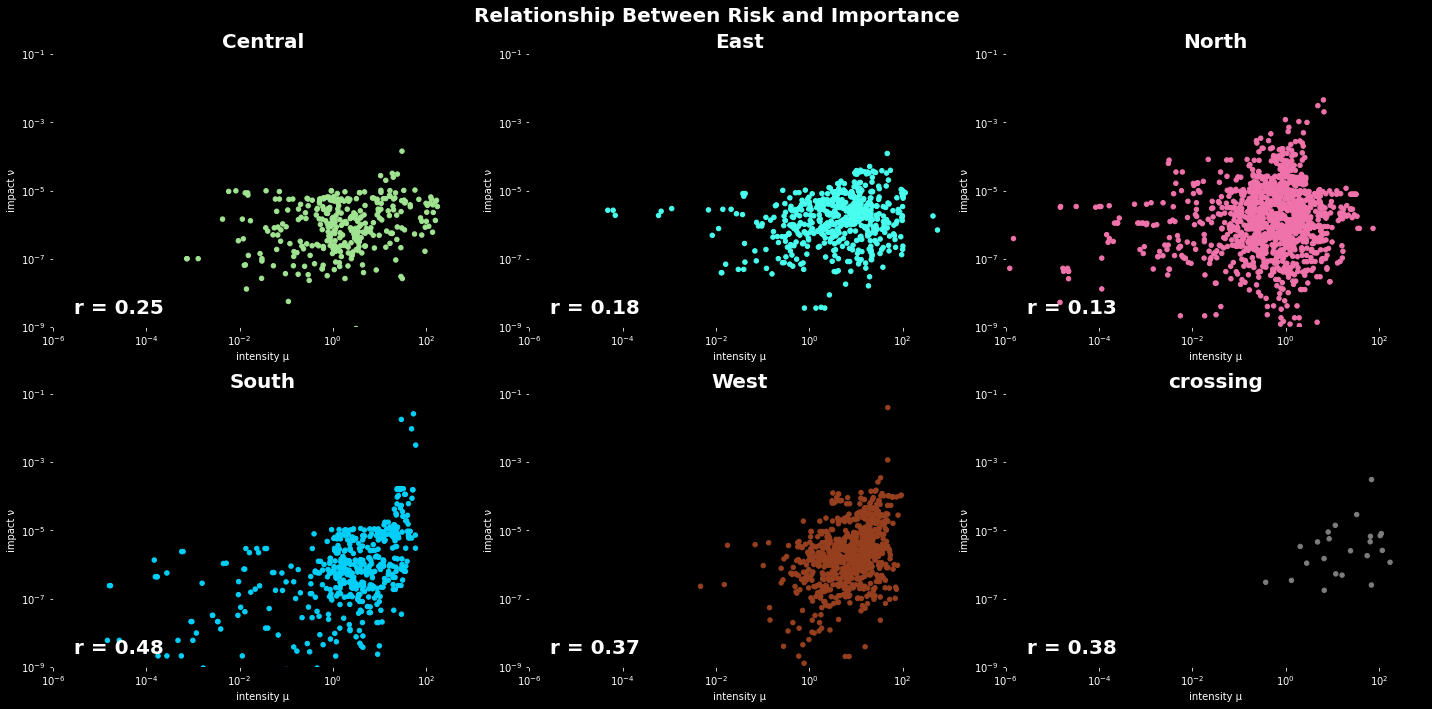

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), facecolor='k', tight_layout=True)

# ravel the axes so that we can loop through them
ax = ax.ravel()

# across each axis plot the data per region
for i, r in enumerate(np.unique(region)):
    joined[joined['region']==r][['risk', 'flow']].plot('risk', 'flow', color=joined[joined['region']==r]['color'], kind='scatter', ax=ax[i])

    # clean it up
    ax[i].set_facecolor('k')
    ax[i].set_title(r, color='w', size=20, weight='bold')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

    # make sure that the axis ticks are the same across all plots
    ax[i].set_ylim([10**-9, 10**-1])
    ax[i].set_xlim([10**-6, 10**3])

    # sparsify the ticks
    ax[i].set_yticks([10**-9, 10**-7, 10**-5, 10**-3, 10**-1])
    ax[i].set_xticks([10**-6, 10**-4, 10**-2, 10**0, 10**2])

    ax[i].set_xlabel("intensity " + u"\u03BC", color="w")
    ax[i].set_ylabel("impact " + u"\u03BD", color="w")
    ax[i].tick_params(axis='x', colors='w')
    ax[i].tick_params(axis='y', colors='w')

    # add the pearson correlation coefficient to the bottom left of each plot
    from scipy.stats import pearsonr
    temp = joined[joined['flow'] > 0]
    temp = temp[temp['risk'] > 0]
    temp = temp[temp['region']==r]
    corr = pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[0].astype(float), pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[1].astype(float)
    ax[i].text(0.05, 0.05, 'r = ' + str(round(corr[0], 2)), color='w', transform=ax[i].transAxes, weight='bold', size=20)

fig.suptitle('Relationship Between Risk and Importance', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-riskvflow-regions.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')


In [36]:
# create a dataframe with the bivariate color scheme
bivariate = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
    "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
}

bivariate = pd.DataFrame(bivariate)

In [37]:
# average tween_weighted and index by to
avg_to = joined.groupby('source', as_index=False).mean()[['source', 'risk', 'flow']]
avg_fr = joined.groupby('target', as_index=False).mean()[['target', 'risk', 'flow']]

# merge the two dataframes
avg = avg_to.merge(avg_fr, left_on='source', right_on='target', how='outer', suffixes=['_to', '_from'])

# replace all nan values with 0
avg = avg.fillna(0)

# calculate the mean of the two
avg['risk'] = (avg['risk_to'] + avg['risk_from']) / 2
avg['flow'] = (avg['flow_to'] + avg['flow_from']) / 2
avg['Agglomeration_ID'] = avg['source']

# drop the columns we don't need
avg = avg[['Agglomeration_ID', 'risk', 'flow']]

# join the nodes dataframe to the avg dataframe
avg = avg.merge(nodes, on='Agglomeration_ID')
avg = gpd.GeoDataFrame(avg, geometry=gpd.points_from_xy(avg['x'], avg['y'], crs='epsg:4326'))
avg = avg.to_crs('epsg:3857')

avg.head()

,Agglomeration_ID,risk,flow,agglosName,x,y,Pop2015,ISO3,Region,Between,degree,geometry
0,1.0,0.706287,8.956461e-04,10 Ramadan,31.741000,30.288000,158515,EGY,North,3.365216e+07,10,POINT (3533391.957 3540623.536)
1,6.0,7.087186,1.305750e-07,Aadado,46.626867,6.138732,60300,SOM,East,1.476806e+04,2,POINT (5190479.136 684671.647)
2,9.0,11.785183,3.153606e-05,Aba,7.357000,5.224000,1687158,NGA,West,1.812137e+07,5,POINT (818977.494 582340.419)
3,10.0,0.000000,3.072530e-07,Aba,30.216358,3.865970,73000,COD,Central,2.820871e+04,2,POINT (3363669.531 430684.701)
4,11.0,0.000000,9.393630e-07,Aba al-Waqf,30.814657,28.584467,47881,EGY,North,5.330121e+05,1,POINT (3430271.982 3322863.544)


Text(-0.1, 0.5, 'intensity→')

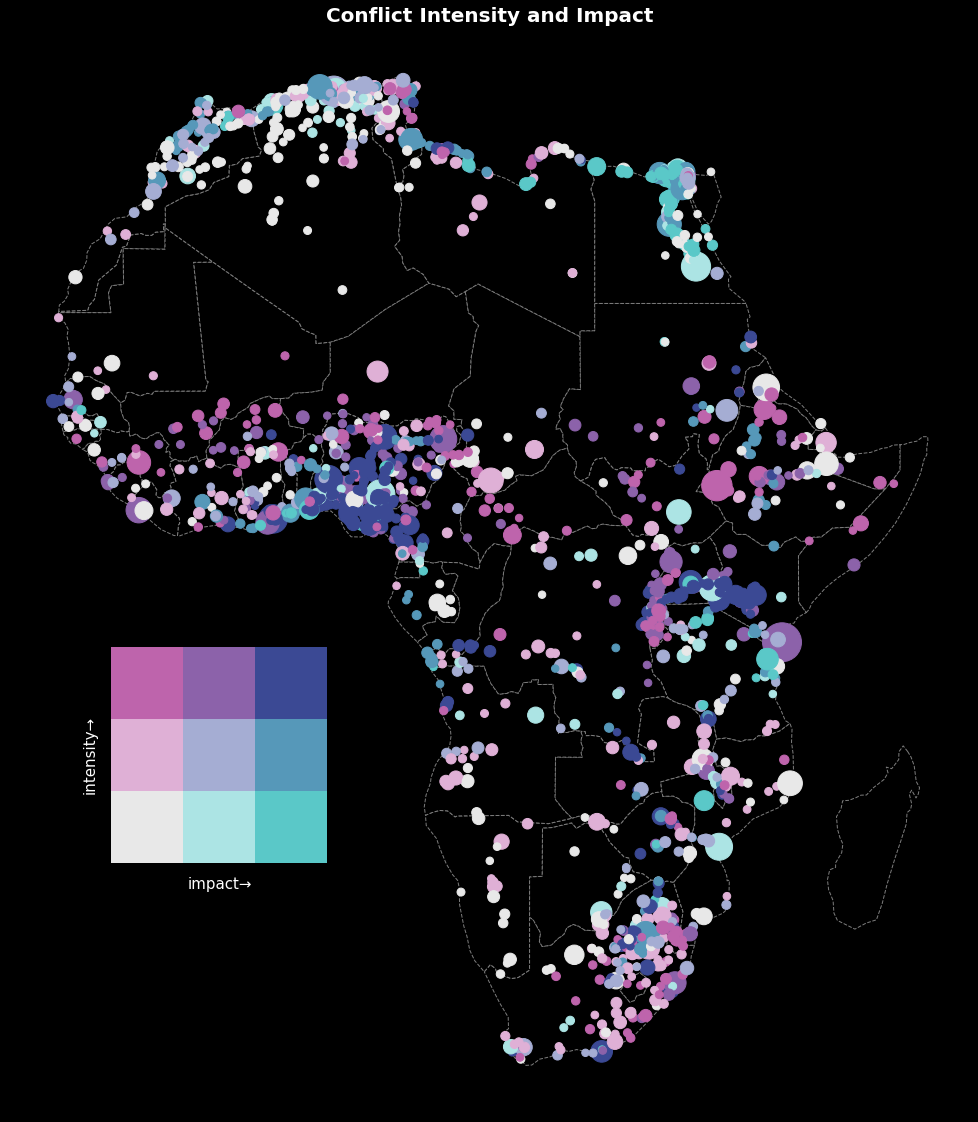

In [38]:
# create a dataframe with the bivariate color scheme
bivariate = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
    "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
}

bivariate = pd.DataFrame(bivariate)

# convert tween_weighted into 3  quantiles 
avg['flow_qtile'] = pd.qcut(avg['flow'].rank(method='first'), 3, labels=["1", "2", "3"])
# replace nan with "1"
avg['flow_qtile'] = avg['flow_qtile'].fillna("1")

# convert index into 3 quantiles
avg['risk_qtile'] = pd.qcut(avg['risk'].rank(method='first'), 3, labels=["1", "2", "3"])
# replace nan with "1"
avg['risk_qtile'] = avg['risk_qtile'].fillna("1")

# join the two quantiles together
avg['class'] = avg['risk_qtile'].astype(str) + "-" + avg['flow_qtile'].astype(str)

# merge the bivariate color scheme with the data
avg = avg.merge(bivariate, on='class')

# create a matplotlib categorical color map with the bi-variate color scheme
from matplotlib.colors import ListedColormap
bmap = ListedColormap(bivariate['color'].values)

# create a geodataframe from the joined dataframe
gdf = gpd.GeoDataFrame(avg)

# make fig and ax objects
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k')

# plot africa with no fill and dashed lines as a base layer
africa.to_crs(avg.crs).plot(color='k', edgecolor='#7c7c7c', linestyle='--', ax=ax)

# plot it with the "class" column and use the categorical color map
# edges_gdf.plot(color='w', ax=ax)
gdf.sort_values('Pop2015', ascending=False).plot(column='class', cmap=bmap, ax=ax, markersize=np.sqrt(gdf['Pop2015'] / 10))

# clean it up
ax.set_facecolor('k')
ax.set_title('Conflict Intensity and Impact', color='w', size=20, weight='bold')
ax.set_axis_off()

# make a subplot in the bottom left corner
sub = fig.add_axes([0.25, 0.3, 0.15, 0.15])

sub.imshow(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]), cmap=bmap)

# turn it 90 degrees
sub.set_xticks([])
sub.set_yticks([])
sub.set_xticklabels([])
sub.set_yticklabels([])
sub.set_frame_on(False)
sub.invert_yaxis()
sub.set_aspect('equal')

# add axis titles that say "Conflict Intensity" and "Impact"
sub.text(0.5, -0.1, 'impact' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, color='w')
sub.text(-0.1, 0.5, 'intensity' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, rotation=90, color='w')

# save this plot as a high resolution png
plt.savefig('../viz/africapolis-riskvflow-map.png', dpi=300, bbox_inches='tight', pad_inches=0)


Text(-0.1, 0.5, 'intensity→')

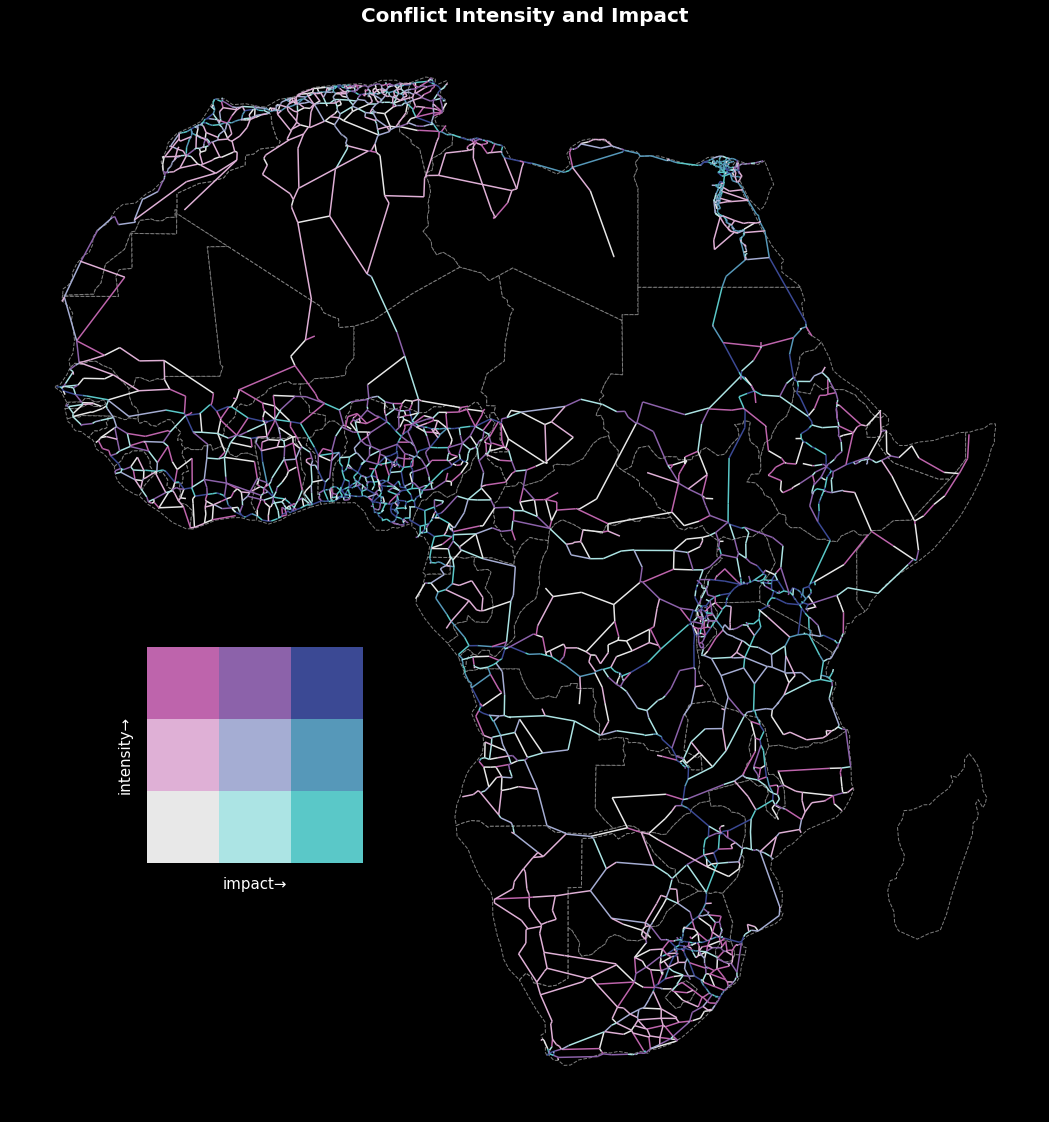

In [39]:
# create a dataframe with the bivariate color scheme
bivariate = {
    "class": ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2", "1-3", "2-3", "3-3"],
    "color": ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]
}

bivariate = pd.DataFrame(bivariate)

# copy data
ready = joined.copy()

# convert tween_weighted into 3  quantiles 
ready['flow_qtile'] = pd.qcut(ready['flow'].rank(method='first'), 3, labels=["1", "2", "3"])

# convert index into 3 quantiles
ready['risk_qtile'] = pd.qcut(ready['risk'].rank(method='first'), 3, labels=["1", "2", "3"])

# # replace na values with the first quantile
# ready['flow_qtile'] = ready['flow_qtile'].fillna("1")
# ready['risk_qtile'] = ready['risk_qtile'].fillna("1")

# join the two quantiles together
ready['class'] = ready['risk_qtile'].astype(str) + "-" + ready['flow_qtile'].astype(str)

# merge the bivariate color scheme with the data
ready = ready.merge(bivariate, on='class')

# create a matplotlib categorical color map with the bi-variate color scheme
from matplotlib.colors import ListedColormap
bmap = ListedColormap(bivariate['color'].values)

# make fig and ax objects
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k')

# plot africa with no fill and dashed lines as a base layer
africa.to_crs(ready.crs).plot(color='k', edgecolor='#7c7c7c', linestyle='--', ax=ax)

# plot it with the "class" column and use the categorical color map
# joined.plot(color='w', ax=ax)
ready.plot(column='class', cmap=bmap, ax=ax)

# clean it up
ax.set_facecolor('k')
ax.set_title('Conflict Intensity and Impact', color='w', size=20, weight='bold')
ax.set_axis_off()

# make a subplot in the bottom left corner
sub = fig.add_axes([0.25, 0.3, 0.15, 0.15])

sub.imshow(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]), cmap=bmap)

# turn it 90 degrees
sub.set_xticks([])
sub.set_yticks([])
sub.set_xticklabels([])
sub.set_yticklabels([])
sub.set_frame_on(False)
sub.invert_yaxis()
sub.set_aspect('equal')

# add axis titles that say "Conflict Intensity" and "Impact"
sub.text(0.5, -0.1, 'impact' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, color='w')
sub.text(-0.1, 0.5, 'intensity' + u"\u2192", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=15, rotation=90, color='w')

# save this plot as a high resolution png
plt.savefig('../viz/africapolis-riskvflow-edges.png', dpi=300, bbox_inches='tight', pad_inches=0)